In [37]:
%load_ext autoreload
%autoreload 2
from constants import *
from plot_config import *
from sample_analysis import *
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
# Failure times loading parameters
N_SAMPLES = 30
N_SEGMENTS = 2
start_id = 70
stop_id = start_id + N_SAMPLES
IDS = np.arange(start_id, stop_id)
FILE_NAMES = [f'id=00{str(id)}.h5' for id in IDS]

In [113]:
SIGMA = 6    # Sets the timescale of avalanches
TAU = 1.27  # Exponent of the power-law distribution of avalanche sizes

In [114]:
COMPUTE_ACTIVITY_FOR_RANDOM_HEIGHTS = True
COMPUTE_ACTIVITY_FOR_GIVEN_HEIGHTS = True

THRESHOLD = 10

# Number of peaks to consider when randomly selecting peaks
RANDOM_SEED = 0
N_RANDOM_PEAKS = 1000

# Number of time windows to consider when counting events
T = 30
T_START = 1e-8
T_END = 2

# Number of peak heights to consider when filtering peaks
N_H = 6
START_STD_H = 4
END_STD_H = 9
VAR_H = 0.05

In [41]:
all_failure_times, _ = load_failure_data(filenames=FILE_NAMES,
                                         directory=FAILURE_DATA_DIR,
                                         loading_segments=N_SEGMENTS,
                                         verbose=False)

for failure_times in all_failure_times:
    failure_times /= TAU_ALPHA

100%|██████████| 30/30 [00:34<00:00,  1.16s/it]


In [ ]:
all_heights_stats = all_sample_heights_stats(all_failure_times=all_failure_times, 
                                             sigma=SIGMA,
                                             threshold=THRESHOLD, 
                                             save=True,
                                             filename=f"heights_{start_id}-{stop_id-1}_{N_SEGMENTS}seg_sigma{SIGMA}_threshold{THRESHOLD}.pkl")
                                             
MEAN_H = all_heights_stats['mean_all_h']
STD_H = all_heights_stats['std_all_h']
all_peak_heights = all_heights_stats['all_peak_h']

print(f"Number of peaks across {N_SAMPLES} samples: {len(all_peak_heights)}")
print(f"Mean height: {MEAN_H}")
print(f"Std height: {STD_H}")

N_STD = np.linspace(START_STD_H, END_STD_H, N_H)
HEIGHTS = MEAN_H + N_STD * STD_H
print(f"Peak heights: {HEIGHTS}")

Computing heights:   3%|▎         | 1/30 [00:01<00:42,  1.47s/it]

In [19]:
output_dicts = []
for i, failure_times in enumerate(all_failure_times):
    print(f"SAMPLE {i+1}")
    output_dicts.append(
        sample_analysis(times=failure_times, 
                        sigma=SIGMA,
                        threshold=THRESHOLD,
                        compute_activity_for_random_heights=COMPUTE_ACTIVITY_FOR_RANDOM_HEIGHTS,
                        compute_activity_for_given_heights=COMPUTE_ACTIVITY_FOR_GIVEN_HEIGHTS,
                        n_random_peaks=N_RANDOM_PEAKS,
                        heights=HEIGHTS,
                        var_h=VAR_H,
                        t_start=T_START,
                        t_stop=T_END,
                        num_time_windows=T, 
                        save=True,
                        filename=f"sample_{IDS[i]}_{N_SEGMENTS}seg_sigma{SIGMA}_threshold{THRESHOLD}.pkl",)
    )
    print(f"{50*'='}\n")

SAMPLE 1
Computing activity for random heights
- Number of random peaks =  530


KeyboardInterrupt: 

In [8]:
if COMPUTE_ACTIVITY_FOR_RANDOM_HEIGHTS:
    random_time_windows = output_dicts[0]['random_time_windows']
    
    all_random_n_before = np.concatenate([output_dicts[i]['random_n_before'] for i in range(N_SAMPLES)], axis=0)
    mean_random_n_before = np.mean(all_random_n_before, axis=0)
    std_random_n_before = np.std(all_random_n_before, axis=0, ddof=1)

    all_random_n_after = np.concatenate([output_dicts[i]['random_n_after'] for i in range(N_SAMPLES)], axis=0)
    mean_random_n_after = np.mean(all_random_n_after, axis=0)
    std_random_n_after = np.std(all_random_n_after, axis=0, ddof=1)
    
    all_random_n_peaks = np.sum([output_dicts[i]['n_random_peaks'] for i in range(N_SAMPLES)], axis=0)
    
    random_activity_before = all_random_n_before / random_time_windows
    mean_random_activity_before = np.mean(random_activity_before, axis=0)
    std_random_activity_before = np.std(random_activity_before, axis=0, ddof=1)
    
    random_activity_after = all_random_n_after / random_time_windows
    mean_random_activity_after = np.mean(random_activity_after, axis=0)
    std_random_activity_after = np.std(random_activity_after, axis=0, ddof=1)

In [9]:
# Concatenate across samples for the same peak height
if COMPUTE_ACTIVITY_FOR_GIVEN_HEIGHTS:
    time_windows = output_dicts[0]['time_windows']
    
    all_n_before = [output_dicts[i]['n_before'] for i in range(N_SAMPLES)]
    all_n_before = concatenate_result(all_n_before, HEIGHTS, N_SAMPLES)
    mean_n_before = {h: np.mean(all_n_before[h], axis=0) for h in HEIGHTS}
    std_n_before = {h: np.std(all_n_before[h], axis=0, ddof=1) for h in HEIGHTS}
    
    all_n_after = [output_dicts[i]['n_after'] for i in range(N_SAMPLES)]
    all_n_after = concatenate_result(all_n_after, HEIGHTS, N_SAMPLES)
    mean_n_after = {h: np.mean(all_n_after[h], axis=0) for h in HEIGHTS}
    std_n_after = {h: np.std(all_n_after[h], axis=0, ddof=1) for h in HEIGHTS}
    
    all_n_peaks = [output_dicts[i]['n_peaks'] for i in range(N_SAMPLES)]
    all_n_peaks = {h: np.sum([all_n_peaks[i][h] for i in range(N_SAMPLES)]) for h in HEIGHTS}
    
    activity_before = {h: all_n_before[h] / time_windows for h in HEIGHTS}
    mean_activity_before = {h: np.mean(activity_before[h], axis=0) for h in HEIGHTS}
    std_activity_before = {h: np.std(activity_before[h], axis=0, ddof=1) for h in HEIGHTS}
    
    activity_after = {h: all_n_after[h] / time_windows for h in HEIGHTS}
    mean_activity_after = {h: np.mean(activity_after[h], axis=0) for h in HEIGHTS}
    std_activity_after = {h: np.std(activity_after[h], axis=0, ddof=1) for h in HEIGHTS}
    
    normalized_mean_activity_before = {h: mean_activity_before[h] / mean_activity_before[h][0] for h in HEIGHTS}
    normalized_mean_activity_after = {h: mean_activity_after[h] / mean_activity_after[h][0] for h in HEIGHTS}

C:\Users\mortgat\AppData\Local\Temp\ipykernel_14724\3123504418.py:26: RuntimeWarning: divide by zero encountered in divide
  normalized_mean_activity_before = {h: mean_activity_before[h] / mean_activity_before[h][0] for h in HEIGHTS}
C:\Users\mortgat\AppData\Local\Temp\ipykernel_14724\3123504418.py:26: RuntimeWarning: invalid value encountered in divide
  normalized_mean_activity_before = {h: mean_activity_before[h] / mean_activity_before[h][0] for h in HEIGHTS}
C:\Users\mortgat\AppData\Local\Temp\ipykernel_14724\3123504418.py:27: RuntimeWarning: divide by zero encountered in divide
  normalized_mean_activity_after = {h: mean_activity_after[h] / mean_activity_after[h][0] for h in HEIGHTS}
C:\Users\mortgat\AppData\Local\Temp\ipykernel_14724\3123504418.py:27: RuntimeWarning: invalid value encountered in divide
  normalized_mean_activity_after = {h: mean_activity_after[h] / mean_activity_after[h][0] for h in HEIGHTS}


# Distribution of Peak Heights

In [ ]:
fit = powerlaw.Fit(all_peak_heights, xmin=min(all_peak_heights), xmax=max(all_peak_heights), discrete=False)
fit2 = powerlaw.Fit(all_peak_heights, xmin=min(all_peak_heights), xmax=max(all_peak_heights), discrete=True)
print(f"Exponent: {fit.alpha}")
print(f"Error: {fit.sigma}")

cmap = plt.get_cmap('jet')
c = [cmap(i) for i in np.linspace(0.15, 0.9, 2)]

fig, ax = plt.subplots(figsize=(8, 6))
fit.plot_pdf(color=c[0], marker='o', linestyle='None', 
             ax=ax, label=rf'$\tau_{{\rm exp}}=-{fit.alpha:.3f}$',
             markeredgecolor='black', alpha=0.5)
fit.power_law.plot_pdf(color=c[1], linestyle='--', ax=ax)

fit2.plot_pdf(color='black', marker='o', linestyle='None', 
              ax=ax, label=rf'$\tau_{{\rm exp}}=-{fit2.alpha:.3f}$',
              markeredgecolor='black', alpha=0.5)
fit2.power_law.plot_pdf(color='black', linestyle='--', ax=ax)

# h_plot = np.linspace(min(all_peak_heights), max(all_peak_heights), 100)
# ax.plot(h_plot, h_plot**-TAU, color='black', linestyle='--', label=rf'$h^{{\tau}}$')
ax.set_xlabel(r'$\boldsymbol{h}$')
ax.set_ylabel(r'$\boldsymbol{P(h)}$')
ax.legend()
plt.grid(True, alpha=0.4, linestyle='--', which='both')
plt.ylim(1e-13, 5e-6)
plt.show()

# Mean Activity for Random Peak Heights

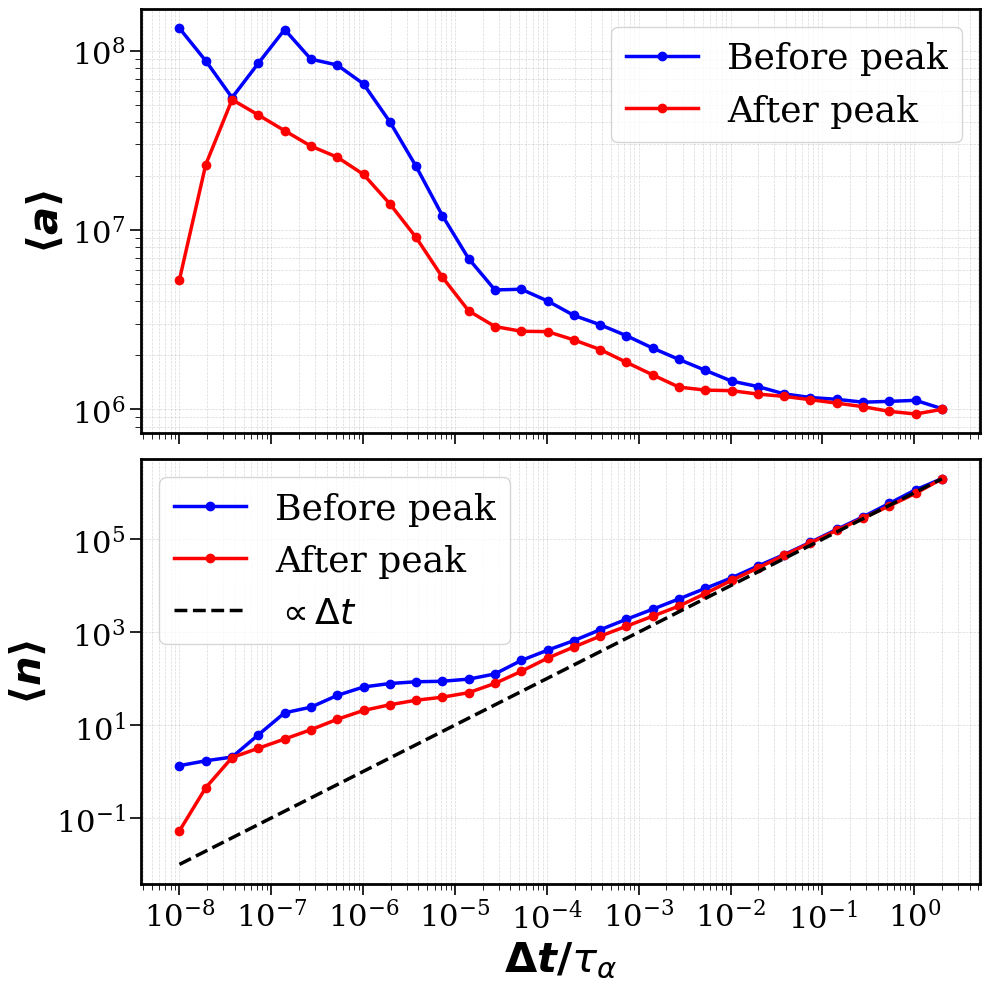

In [11]:
if COMPUTE_ACTIVITY_FOR_RANDOM_HEIGHTS:
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(10, 10))
    
    axs[0].plot(random_time_windows, mean_random_activity_before, marker='o', linestyle='-', color='b', label='Before peak')
    axs[0].plot(random_time_windows, mean_random_activity_after, marker='o', linestyle='-', color='r', label='After peak')
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].set_ylabel(r'$\boldsymbol{\langle a \rangle}$')
    axs[0].legend(loc='best')
    axs[0].grid(True, alpha=0.3, which='both', ls='--')
    
    axs[1].plot(random_time_windows, mean_random_n_before, marker='o', linestyle='-', color='b', label='Before peak')
    axs[1].plot(random_time_windows, mean_random_n_after, marker='o', linestyle='-', color='r', label='After peak')
    axs[1].plot(random_time_windows, 1e6*random_time_windows, linestyle='--', color='black', label=r'$\propto \Delta t$')
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xlabel(r'$\boldsymbol{\Delta t/\tau_\alpha}$')
    axs[1].set_ylabel(r'$\boldsymbol{\langle n \rangle}$')
    axs[1].legend(loc='best')
    axs[1].grid(True, alpha=0.3, which='both', ls='--')
    
    plt.tight_layout()
    plt.show()

# Mean Activity for Given Peak Heights

C:\Users\mortgat\AppData\Local\Temp\ipykernel_14724\3800586387.py:21: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[0].set_ylim(min([mean_n_before[h].min() for h in HEIGHTS] + [mean_n_after[h].min() for h in HEIGHTS]),
C:\Users\mortgat\AppData\Local\Temp\ipykernel_14724\3800586387.py:30: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[1].set_ylim(min([mean_activity_before[h].min() for h in HEIGHTS] + [mean_activity_after[h].min() for h in HEIGHTS]),


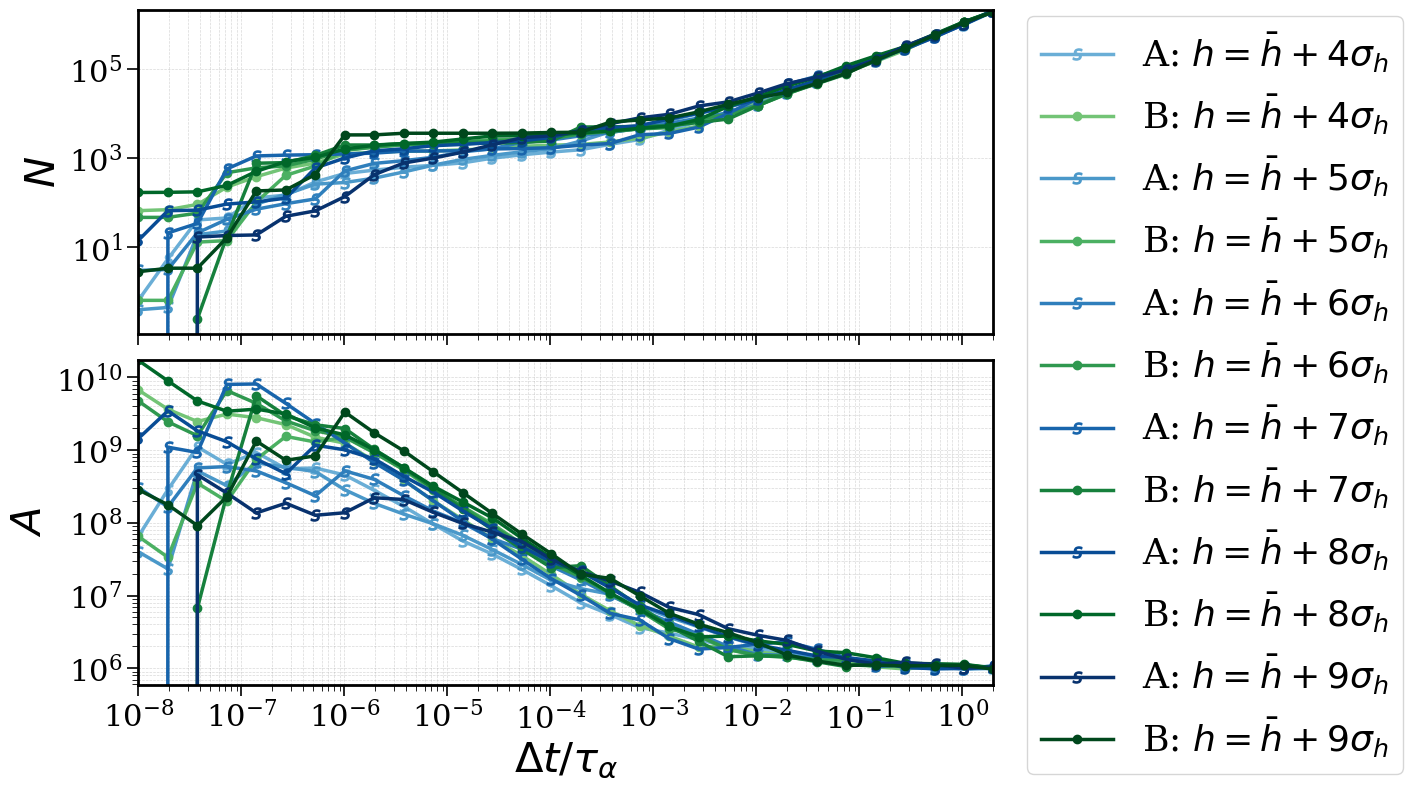

In [12]:
if COMPUTE_ACTIVITY_FOR_GIVEN_HEIGHTS:
    cmap_before = plt.get_cmap('Greens')
    colors_before = cmap_before(np.linspace(0.5, 0.99, N_H))
    cmap_after = plt.get_cmap('Blues')
    colors_after = cmap_after(np.linspace(0.5, 0.99, N_H))
    
    fig, axs = plt.subplots(2, 1, figsize=(10,8), sharex=True)
    for i, (h, n_std) in enumerate(zip(HEIGHTS, N_STD)):
        axs[0].plot(time_windows, mean_n_after[h], linestyle='-', markersize=8,
                    marker=r'$S$', color=colors_after[i], label=rf'A: $h=\bar h+{n_std:.0f}\sigma_h$')
        axs[0].plot(time_windows, mean_n_before[h], linestyle='-', markersize=6,
                    marker='o', color=colors_before[i], label=rf'B: $h=\bar h+{n_std:.0f}\sigma_h$')
        axs[1].plot(time_windows, mean_activity_after[h], linestyle='-', marker=r'$S$', color=colors_after[i], markersize=8)
        axs[1].plot(time_windows, mean_activity_before[h], linestyle='-', marker='o', color=colors_before[i], markersize=6)
    
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].set_ylabel(r'$N$')
    axs[0].grid(True, alpha=0.3, which='both', ls='--')
    axs[0].set_xlim(min(time_windows), max(time_windows))
    axs[0].set_ylim(min([mean_n_before[h].min() for h in HEIGHTS] + [mean_n_after[h].min() for h in HEIGHTS]),
                    max([mean_n_before[h].max() for h in HEIGHTS] + [mean_n_after[h].max() for h in HEIGHTS]))
    
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xlabel(r'$\Delta t/\tau_\alpha$')
    axs[1].set_ylabel(r'$A$')
    axs[1].grid(True, alpha=0.3, which='both', ls='--')
    axs[1].set_xlim(min(time_windows), max(time_windows))
    axs[1].set_ylim(min([mean_activity_before[h].min() for h in HEIGHTS] + [mean_activity_after[h].min() for h in HEIGHTS]),
                    max([mean_activity_before[h].max() for h in HEIGHTS] + [mean_activity_after[h].max() for h in HEIGHTS]))

    lines_labels = [axs[0].get_legend_handles_labels()]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(lines, labels, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    
    plt.tight_layout()
    plt.show()

C:\Users\mortgat\AppData\Local\Temp\ipykernel_14724\2794369781.py:21: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[0].set_ylim(min([mean_n_before[h].min() for h in HEIGHTS] + [mean_n_after[h].min() for h in HEIGHTS]),


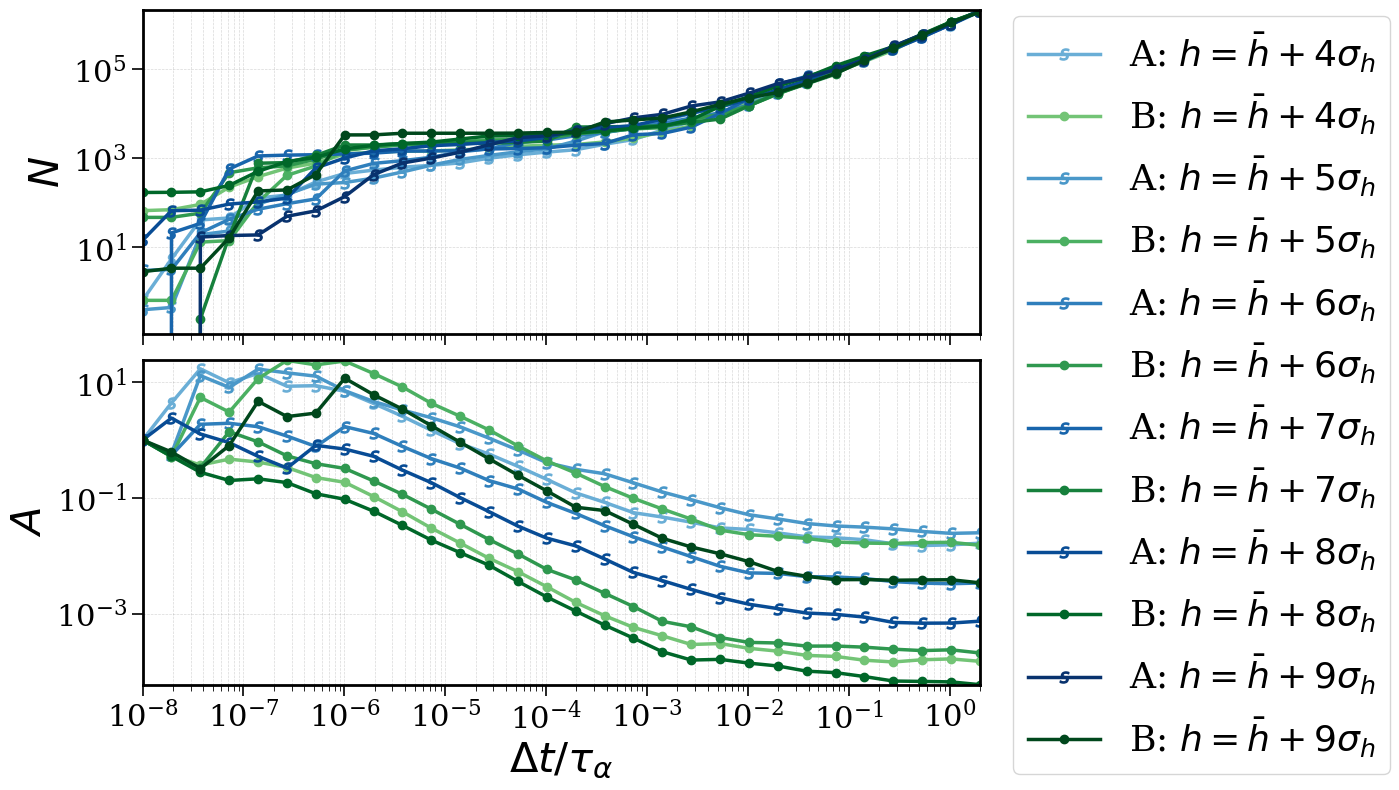

In [13]:
if COMPUTE_ACTIVITY_FOR_GIVEN_HEIGHTS:
    cmap_before = plt.get_cmap('Greens')
    colors_before = cmap_before(np.linspace(0.5, 0.99, N_H))
    cmap_after = plt.get_cmap('Blues')
    colors_after = cmap_after(np.linspace(0.5, 0.99, N_H))

    fig, axs = plt.subplots(2, 1, figsize=(10,8), sharex=True)
    for i, (h, n_std) in enumerate(zip(HEIGHTS, N_STD)):
        axs[0].plot(time_windows, mean_n_after[h], linestyle='-', markersize=8,
                    marker=r'$S$', color=colors_after[i], label=rf'A: $h=\bar h+{n_std:.0f}\sigma_h$')
        axs[0].plot(time_windows, mean_n_before[h], linestyle='-', markersize=6,
                    marker='o', color=colors_before[i], label=rf'B: $h=\bar h+{n_std:.0f}\sigma_h$')
        axs[1].plot(time_windows, normalized_mean_activity_after[h], linestyle='-', marker=r'$S$', color=colors_after[i], markersize=8)
        axs[1].plot(time_windows, normalized_mean_activity_before[h], linestyle='-', marker='o', color=colors_before[i], markersize=6)

    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].set_ylabel(r'$N$')
    axs[0].grid(True, alpha=0.3, which='both', ls='--')
    axs[0].set_xlim(min(time_windows), max(time_windows))
    axs[0].set_ylim(min([mean_n_before[h].min() for h in HEIGHTS] + [mean_n_after[h].min() for h in HEIGHTS]),
                    max([mean_n_before[h].max() for h in HEIGHTS] + [mean_n_after[h].max() for h in HEIGHTS]))

    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xlabel(r'$\Delta t/\tau_\alpha$')
    axs[1].set_ylabel(r'$A$')
    axs[1].grid(True, alpha=0.3, which='both', ls='--')
    axs[1].set_xlim(min(time_windows), max(time_windows))
    axs[1].set_ylim(min([normalized_mean_activity_before[h].min() for h in HEIGHTS] + [normalized_mean_activity_after[h].min() for h in HEIGHTS]),
                    max([normalized_mean_activity_before[h].max() for h in HEIGHTS] + [normalized_mean_activity_after[h].max() for h in HEIGHTS]))

    lines_labels = [axs[0].get_legend_handles_labels()]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(lines, labels, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

    plt.tight_layout()
    plt.show()